In [11]:
using LibPQ, Tables, Plots, HTTP, CSV, Random, StatsBase, 
FreqTables, SQLite, Base, Dates, JuliaDB, StatsPlots, Statistics, StructArrays, NPFinancial,
Random, Distributions
using Base: show_supertypes
plotly()


Plots.PlotlyBackend()

In [6]:
using Pkg;
Pkg.add("Distributions");


   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [31c24e10] + Distributions v0.23.8
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
Precompiling project...
  ? FFTW_jll
  ? OpenSpecFun_jll
  ? NearestNeighbors
  ? OpenSSL_jll
  ? libsodium_jll
  ? Polynomials
  ? SQLite_jll
  ? Widgets
  ? LogExpFunctions
  ? CategoricalArrays
  ? OnlineStatsBase
  ? Memento
  ? OffsetArrays
  ? ForwardDiff
  ? ZeroMQ_jll
  ? StatsFuns
  ? NPFinancial
  ? DoubleFloats
  ? OnlineStats
  ? FFTW


In [178]:
Random.seed!(123);
function fmt(d::DateTime)
    Dates.format(d, "yyyy-mm-dd")
end
function p2(p1::Number, r::Number, t::Number)
    return Float64(p1)*((1+Float64(r))^Float64(t))
end

function t(p1::Number, p2::Number, r::Number)
    return log(Float64(p2)/Float64(p1)) / log(1+Float64(r))
end

function p1(p2::Number, r::Number, t::Number)
    return Float64(p2)/((1+Float64(r))^Float64(t))
end

function r(p1::Number, p2::Number, t::Number)
    power = log(Float64(p2)/Float64(p1))/Float64(t)
    return exp(power) - 1
end

function emi(p1::Number, r::Number, t::Number)
    x::Float64 = (1.0 + Float64(r))^Float64(t)
    return Float64(p1) * Float64(r) * x / (x - 1)
end
function splt(s, delim=r"\s+")
    ar = split(s, delim)
    ar = strip.(ar)
    ar = filter(s -> s != Missing && length(s)>0, ar)
    return ar
end
function doplot(x, y)
#     plot(x, y; hover=fmt.(x).*"   ".*fmt.(y), size=(1700, 400,))
    plot(x, y;hover=string.(x).*"   ".*string.(y), size=(1400, 400,))

end
conn = LibPQ.Connection("dbname=sharath")
sqlite = SQLite.DB()

SQLite.DB(":memory:")

2.0


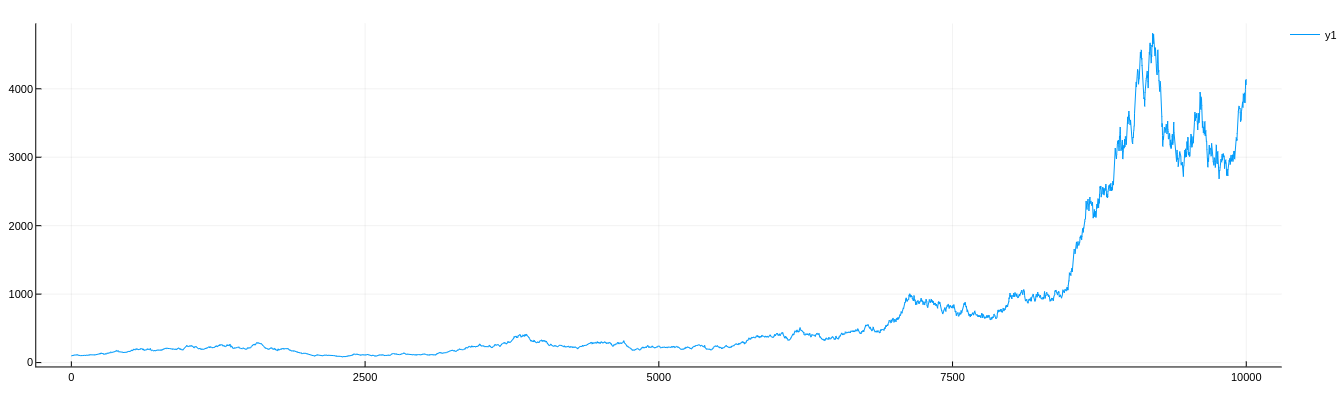

In [328]:
function weiner(s::Vector{Float64}, days::Int, μ::Float64, σ::Float64)
    #s = Vector{Float64}(undef, days)
    s[1] = 100
    a::Float64 = μ/365.0
    b::Float64 = σ/sqrt(365.0)
    ϕ::Vector{Float64} = rand(Normal(0, 1), days)
    for i::Int in 2:days
        s[i] = s[i-1]*(1 + a + ϕ[i]*b)
    end  
    return s
end

function downscale(X::Vector{Int}, Y::Vector{Float64}, points::Int)
    days::Int = length(X)
    step::Float64 = 1
    if days > points
        step = days / points
    end
    println(step)
    XX = Vector{Float64}(undef, 0)
    YY = Vector{Float64}(undef, 0)
    for i in 1:step:days
        push!(XX, Int(i))
        push!(YY, Y[min(days, Int(round(i)))])
    end
    return XX, YY
end
days = 10000
μ, σ = 10.0/100, 30.0/100
# ϕ = rand(Normal(μ, σ*σ/365.0), days)
# histogram(ϕ)
X, Y = downscale(collect(1:days), weiner(Vector{Float64}(undef, days), days, μ, σ), 5000)
doplot(X, Y)
